# Change Detection in Portuguese Soil Using Sequences of Satellite Images

The goal of this project is to identify changes in the soil using sequences of images from the same location, obtained at different time points.

Since they work during the day and the at night, with and without cloud cover, Synthetic Apperture Radar (SAR) sensors are suitable for ground change detection applications. Thus, we will be using images obtained by the ESA Sentinel-1 satellite.

In the development of this project we followed this workflow:

- Understand what a SAR sensor is
- Read ESA's Sentinel-1 satellite documentation (capture modes, polarizations and product levels/data provided)
- Download and view Sentinel-1 products in Python
- Select and test a Deep Learning model for detecting changes in Portuguese soil

## Initialization

Import some Python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

## Obtain Data from Google Earth Engine

To download Sentinel-1 images we choose the Google Earth Engine API.

In the following cell we initialize the API.

In [ ]:
import ee

# trigger the authentication flow
ee.Authenticate()

# initialize the library
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=unnMDt5VRbZPiVsBb4OzvhPmlbs9TErAjQGmVd41d8g&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5iXWYzsmm4U5mzdTKi08loqPurU1bmpjjfizHWrWTV0IQ-27knhnA

Successfully saved authorization token.


Our area of interest is the city of Braga, in the northwest of Portugal. To define this area we use the GeoJSON format, wich is a format for encoding a variety of geographic data structures, based on the JSON format.

In the following cell we define the area of interest.

In [ ]:
coords = [-8.49606, 41.49750, -8.36868, 41.59050]

geoJSON = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": coords
    }
}

aoi = ee.Geometry.Rectangle(coords)

Get the image collection from the Google Earth Engine archives.

In [ ]:
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')                      # specify image archive
                .filterBounds(aoi)                                         # specify area on interest
                .filterDate(ee.Date('2014-01-01'),ee.Date('2021-01-01'))   # specify time period
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) # specify orbit pass 
                .sort('system:time_start'))                                # sort by date

Clip all images to the area of interest.

In [ ]:
# get the image collection as a list
images = collection.toList(collection.size())

print('Number of images available:', images.length().getInfo())

# clip an image to the area of interest
def clip_image(image):
  return ee.Image(image).clip(aoi)

# clip all images to the area of interest
images = ee.List(images.map(clip_image))

Number of images available: 313


Convert data.

In [ ]:
from data_preparation import convert_data

data = convert_data(images)
print(data.shape)

100%|██████████| 313/313 [40:35<00:00,  7.78s/it]


(313, 1024, 1024)


Save data to file.

In [ ]:
np.save('images.npy', data)

## Obtain Data from File

In [2]:
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

data = np.load('drive/MyDrive/Sentinel-1/images.npy')

Mounted at /content/drive


## Data Manipulation

Separate images into pairs to detect changes.

In [5]:
from data_preparation import to_pairs

data = to_pairs(data)

print(data.shape)

(312, 2, 1024, 1024)


Create a set of changes to make the problem supervised.

In [6]:
from data_preparation import to_supervised

threshold = 50
changes = to_supervised(data, threshold)

print(changes.shape)

(312, 1024, 1024)


Slice images and group the data into the shape (number of pairs, number of slices per pair, number of arrays per pair, slice width, slice height).

In [7]:
from data_preparation import slice_data

image_size = 128
data = slice_data(data, image_size)

print(data.shape)

(312, 64, 2, 128, 128)


Slice pairs changes into the shape (number of changes, number of slices, slice width, slice height).

In [8]:
from data_preparation import slice_changes

changes = slice_changes(changes)

print(changes.shape)

(312, 64, 128, 128)


Separate each pair of images.

In [9]:
from data_preparation import separate_pairs

data, changes = separate_pairs(data, changes)

print(data.shape)
print(changes.shape)

(19968, 2, 128, 128)
(19968, 128, 128)


Show a random pair of images and their respective changes.

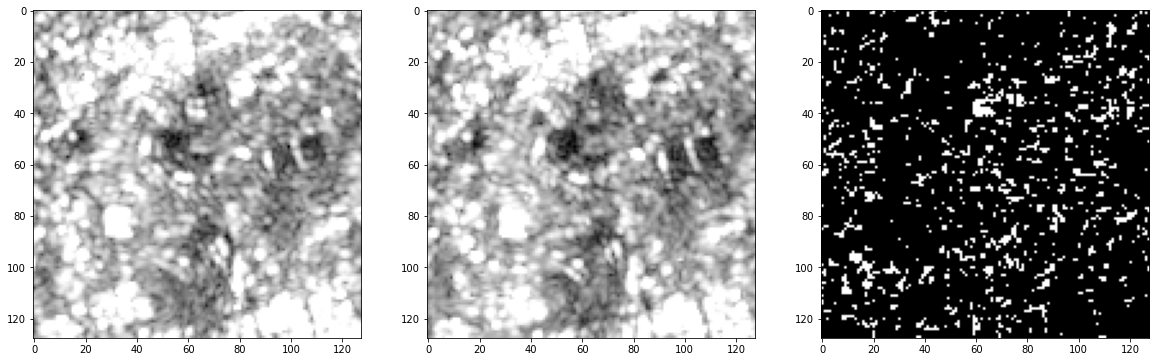

In [10]:
from data_preparation import to_image, denormalize_data

# choose random data from test dataset
n = randint(0, data.shape[0] - 1)
image1 = to_image(data[n][0])
image2 = to_image(data[n][1])
changes1 = to_image(denormalize_data(changes[n]))

# display images
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(changes1)

Normalize data.

In [11]:
from data_preparation import normalize_data

data = normalize_data(data)

Reshape data to fit the Deep Learning model.

In [12]:
from data_preparation import reshape_data

data = reshape_data(data)

print(data.shape)

(19968, 128, 128, 2)


Split data into training, validation and testing sets.

In [13]:
from data_preparation import shuffle_data, split_data

# shuffle data
data, changes = shuffle_data(data, changes)

x_train, y_train, x_test, y_test = split_data(data, changes, 0.9)
x_train, y_train, x_val, y_val = split_data(x_train, y_train, 0.8)
del data
del changes 

print('Training data set shape:', x_train.shape)
print('Training changes set shape:', y_train.shape)
print('Validation data set shape:', x_val.shape)
print('Validation changes set shape:', y_val.shape)
print('Testing data set shape:', x_test.shape)
print('Testing changes set shape:', y_test.shape)

Training data set shape: (14376, 128, 128, 2)
Training changes set shape: (14376, 128, 128)
Validation data set shape: (3595, 128, 128, 2)
Validation changes set shape: (3595, 128, 128)
Testing data set shape: (1997, 128, 128, 2)
Testing changes set shape: (1997, 128, 128)


## U-Net Model

Build U-Net model.

In [14]:
from model import UNet

model = UNet(image_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Training

Compile model and fit it to our data.

Epoch 1/10
450/450 [==============================] - 71s 83ms/step - loss: 0.2295 - precision: 0.6596 - recall: 0.4545 - val_loss: 0.1049 - val_precision: 0.8946 - val_recall: 0.7693
Epoch 2/10
450/450 [==============================] - 37s 82ms/step - loss: 0.0731 - precision: 0.9124 - recall: 0.8581 - val_loss: 0.0470 - val_precision: 0.9449 - val_recall: 0.9127
Epoch 3/10
450/450 [==============================] - 36s 81ms/step - loss: 0.0381 - precision: 0.9514 - recall: 0.9330 - val_loss: 0.0308 - val_precision: 0.9786 - val_recall: 0.9273
Epoch 4/10
450/450 [==============================] - 37s 81ms/step - loss: 0.0269 - precision: 0.9651 - recall: 0.9550 - val_loss: 0.0225 - val_precision: 0.9756 - val_recall: 0.9601
Epoch 5/10
450/450 [==============================] - 37s 81ms/step - loss: 0.0218 - precision: 0.9720 - recall: 0.9650 - val_loss: 0.0218 - val_precision: 0.9417 - val_recall: 0.9904
Epoch 6/10
450/450 [==============================] - 36s 81ms/step - loss: 0.01

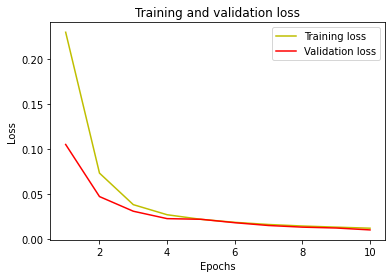

In [15]:
from training import compile_fit

# select loss function
loss = 'binary_crossentropy'
#loss = 'dice'

# select hyperparameters
learning_rate = 1e-3
epochs = 10
batch_size = 32

# generate configuration from hyperparameters
config = [learning_rate, epochs, batch_size]

# compile and fit model
model = compile_fit(model, loss, config, x_train, y_train, x_val, y_val)

Evaluate model with data from test set.

In [16]:
metrics = model.evaluate(x_test, y_test)
loss, precision, recall = metrics

print('Loss:', loss)
print('Precision:', precision)
print('Recall:', recall)

63/63 [==============================] - 2s 29ms/step - loss: 0.0100 - precision: 0.9836 - recall: 0.9942
Loss: 0.010010003112256527
Precision: 0.9836333394050598
Recall: 0.9942288994789124


### Predict

Predict the changes from a random pairs of images from the test set.

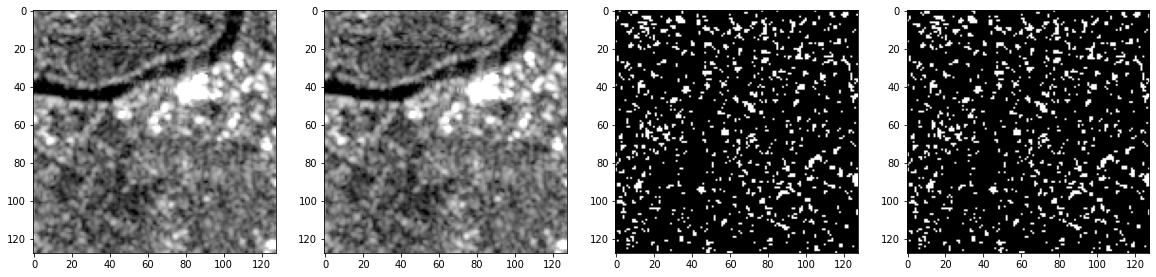

In [17]:
from training import predict_changes

# choose random data from test dataset
n = randint(0, x_test.shape[0] - 1)
input_data = x_test[n]

# predict changes
prediction = predict_changes(model, input_data, image_size)

# convert prediction to an image
prediction_data = denormalize_data(prediction)
prediction_image = to_image(prediction_data)

# process input data and real changes to images
image1 = to_image(denormalize_data(x_test[n].T[0]))
image2 = to_image(denormalize_data(x_test[n].T[1]))
truth_image = to_image(denormalize_data(y_test[n]))

# display images
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(image1)
ax[1].imshow(image1)
ax[2].imshow(truth_image)
ax[3].imshow(prediction_image)

Apply clustering algorithm to ignore minimal changes.

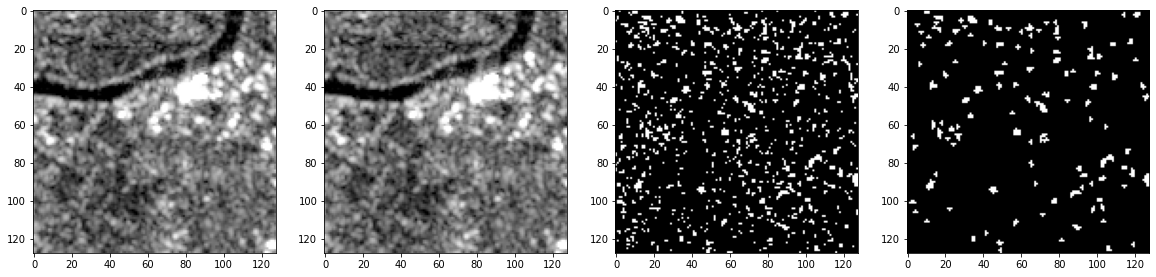

In [18]:
from clustering import run_clustering_image_pil

clustering_image = run_clustering_image_pil(prediction_image)

# display images
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(image1)
ax[1].imshow(image1)
ax[2].imshow(truth_image)
ax[3].imshow(clustering_image)

Save images to files.

In [ ]:
from clustering import to_pil

image1.save('image1.png')
image2.save('image2.png')
truth_image.save('truth.png')
prediction_image.save('prediction.png')
to_pil(clustering_image).save('clustering.png')

## References

- https://arxiv.org/pdf/1812.05815.pdf

- https://www.researchgate.net/profile/Roberto-Arroyo-4/publication/304533064_Street-View_Change_Detection_with_Deconvolutional_Networks/links/5773858508ae6f328f6c29e4/Street-View-Change-Detection-with-Deconvolutional-Networks.pdf

